In [1]:
import numpy as np
import scipy
import scipy.spatial
from scipy.spatial.distance import squareform,pdist,cdist
import matplotlib.pyplot as plt
from scipy.io import mmread

from sklearn.manifold import TSNE
from joblib import Parallel, delayed

from timeit import default_timer as timer

import scanpy as sc
import anndata as ad


from scipy.sparse import csr_matrix
import pandas as pd
import anndata as ad


In [ ]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath('..'))


# Experimnet

### Load data 

In [8]:
# df_meta : E14_5 WLS CTL meta data
# df : E14_5 WLS CTL raw data

In [9]:
cell_types= np.array(df_meta['celltype'].values)
phase_types= np.array(df_meta['Phase'].values)

In [10]:
print(np.unique(cell_types))
print(np.unique(phase_types))

['DC' 'LD' 'UD']
['G1' 'G2M' 'S']


In [11]:
x_orig= df.values.T[1:]
gene_names_orig=  df.values.T[0]

# Preprocess data

In [12]:
x_adata = ad.AnnData(x_orig+0.)

sc.pp.filter_cells(x_adata, min_genes=10)
sc.pp.filter_genes(x_adata, min_cells=3)

sc.pp.normalize_total(x_adata,target_sum=1e6)
sc.pp.log1p(x_adata)
sc.pp.highly_variable_genes(x_adata,n_top_genes=5000)
sc.pp.scale(x_adata)


In [13]:
x = x_adata.X[:,np.where(x_adata.var['highly_variable'])[0]]+0.
gene_names = gene_names_orig[x_adata.var['highly_variable'].index.to_numpy()[np.where(x_adata.var['highly_variable'])].astype(int)]

x.shape

(5572, 5000)

In [16]:
from collections import Counter
print(Counter(cell_types))
print(Counter(phase_types))


Counter({'UD': 3576, 'LD': 1793, 'DC': 203})
Counter({'G1': 2785, 'G2M': 1420, 'S': 1367})


In [18]:
for ct in np.unique(cell_types):
    for pt in np.unique(phase_types):
        
        print( pt+'  percentage within '+ct+'  :'+str( np.round(len(np.where( (cell_types==ct)*(phase_types==pt))[0])/ len(np.where( cell_types==ct)[0]),2)))

G1  percentage within DC  :0.97
G2M  percentage within DC  :0.01
S  percentage within DC  :0.02
G1  percentage within LD  :0.69
G2M  percentage within LD  :0.14
S  percentage within LD  :0.17
G1  percentage within UD  :0.38
G2M  percentage within UD  :0.33
S  percentage within UD  :0.3


### Choose rank

In [19]:
from FP import *

In [21]:
x_SVD = SVD_mean_shifted( x,500)
x_new_SVD= (x_SVD[0][::,:50], x_SVD[1][:50], x_SVD[2][:50,:])

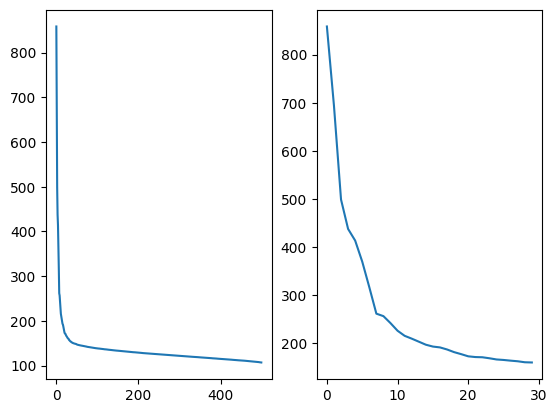

In [22]:
f,ax= plt.subplots(1,2)
ax[0].plot(x_SVD[1])
ax[1].plot(x_SVD[1][:30])

# run algorithm

In [ ]:
K=2
perplexity=40

verbose_updates= True

FP_K2 = FP(K=K, perplexity=perplexity)


In [ ]:
FP_K2.fit(x_new_SVD, verbose_updates= verbose_updates, simulations=100)


# Visualization

In [ ]:
feat_partitions = FP_K2.get_feature_partitions()

In [224]:
emb_all = TSNE(n_components=3, perplexity=40, random_state=42).fit_transform(x_new_SVD[0]*x_new_SVD[1])
emb_FP = [ TSNE(n_components=3, perplexity=40, random_state=42).fit_transform((x_new_SVD[0]*x_new_SVD[1])@x_new_SVD[2][:, feat_partitions[i]]) for i in range(K)]


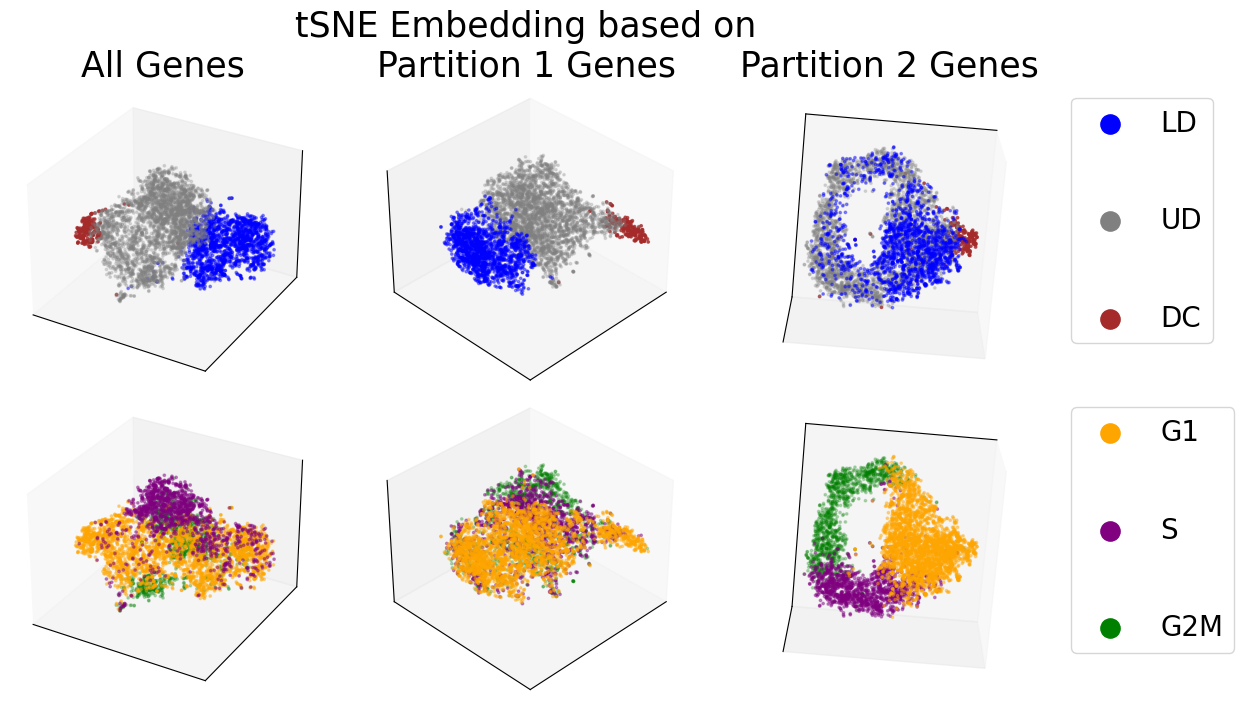

In [233]:
colors1= ['blue','grey','brown']
colors2= ['orange','purple','green']
alpha=0.1
s=3

f,ax= plt.subplots(2,3,figsize=(14,8),subplot_kw={'projection':'3d'})
f.subplots_adjust(wspace=0.01, hspace=0.01)
for i,l in enumerate(['LD','UD','DC']):
    alpha=[0.5,0.3,0.9][i]*0.8

    inds= np.where(np.array(cell_types)==l)[0]
    ax[0,0].scatter(emb_all[inds,0], emb_all[inds,1], emb_all[inds,2],label=l,alpha=alpha,s=s,c=colors1[i])
    ax[0,1].scatter(emb_FP[0][inds,0], emb_FP[0][inds,1], emb_FP[0][inds,2],label=l,alpha=alpha,s=s,c=colors1[i])
    ax[0,2].scatter(emb_FP[1][inds,0], emb_FP[1][inds,1], emb_FP[1][inds,2],label=l,alpha=alpha,s=s,c=colors1[i])

for i,l in enumerate(['G1','S','G2M']):
    alpha=[0.5,0.5,0.3][i]*0.8

    inds= np.where(np.array(phase_types)==l)[0]
    ax[1,0].scatter(emb_all[inds,0], emb_all[inds,1], emb_all[inds,2],label=l,alpha=alpha,s=s,c=colors2[i])
    ax[1,1].scatter(emb_FP[0][inds,0], emb_FP[0][inds,1], emb_FP[0][inds,2],label=l,alpha=alpha,s=s,c=colors2[i])
    ax[1,2].scatter(emb_FP[1][inds,0], emb_FP[1][inds,1], emb_FP[1][inds,2],label=l,alpha=alpha,s=s,c=colors2[i])

l1= ax[0,2].legend(markerscale=8,loc='upper left', bbox_to_anchor=(1.05, 1),fontsize=20,labelspacing=2.5)
l2= ax[1,2].legend(markerscale=8,loc='upper left', bbox_to_anchor=(1.05, 1),fontsize=20,labelspacing=2.5)

for lh in l1.legend_handles: 
    lh.set_alpha(1)
for lh in l2.legend_handles: 
    lh.set_alpha(1)

for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
    a.set_zticks([])


ax[0,0].set_title('All Genes',fontsize=25)
ax[0,1].set_title('tSNE Embedding based on\nPartition 1 Genes',fontsize=25)
ax[0,2].set_title('Partition 2 Genes',fontsize=25)

f.patch.set_facecolor('white')

for a in ax.flatten():
    a.set_facecolor('white')

for i in range(2):
    ax[i,2].view_init(45+60,95)
    ax[i,1].view_init(35,45)


# DMaps

In [59]:
from scipy.spatial.distance import cdist
from scipy.linalg import eigh
def Dmaps(x,W=None, n_neighbors=10,emb_dim=10,alpha=1.):
    
    if W is None:
        dist = cdist(x,x)**2
        dist[np.arange(len(x)),np.arange(len(x)) ]= np.inf
        
        sigma =np.max(np.partition(dist,n_neighbors+1,axis=1)[:,1+n_neighbors])
        W= np.exp(-dist/sigma)
        if alpha>0:
            D= np.sum(W,axis=1)**alpha
            W= (1/D[None,:])*W/D[:,None]
        D= np.sum(W,axis=1)
        
        W = 1/np.sqrt(D)[:,None]*W/np.sqrt(D)[None,:]
        eigs,vecs = eigh(W,subset_by_index=[len(W)-emb_dim-1, len(W)-2])
        vecs =vecs/np.sqrt(D)[:,None]
        vecs = vecs/np.sqrt(np.sum(vecs**2,axis=0,keepdims=True))
        
    else:
        eigs,vecs = eigh(W,subset_by_index=[len(W)-emb_dim-1, len(W)-2])
    order = np.argsort(eigs)[::-1]
    return np.real(vecs)[:,order]*np.real(eigs)[order]



In [60]:
dmaps_all = Dmaps(x_new_SVD[0]*x_new_SVD[1])
dmaps_FP =[ Dmaps((x_new_SVD[0]*x_new_SVD[1])@x_new_SVD[2][:, feat_partitions[i]]) for i in range(K)]

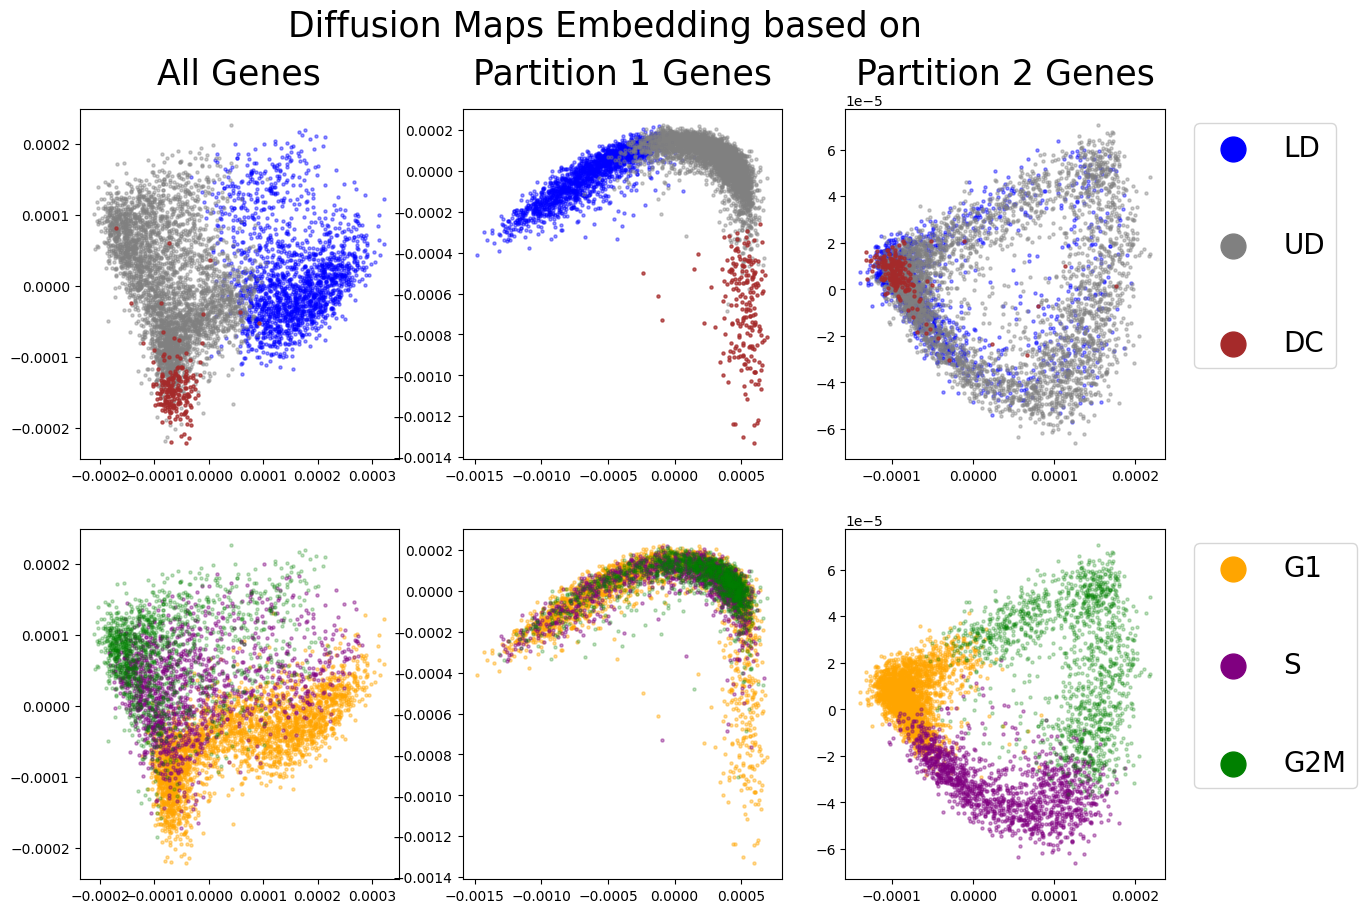

In [61]:
colors1= ['blue','grey','brown']
colors2= ['orange','purple','green']
alpha=0.1
s=5
f,ax= plt.subplots(2,3,figsize=(14,10))#,subplot_kw={'projection':'3d'})
for i,l in enumerate(['LD','UD','DC']):
    alpha=[0.5,0.5,0.9][i]*0.8

    inds= np.where(np.array(cell_types)==l)[0]
    ax[0,0].scatter(dmaps_all[inds,0],dmaps_all[inds,1],label=l,alpha=alpha,s=s,c=colors1[i])
    ax[0,1].scatter(dmaps_FP[0][inds,0],dmaps_FP[0][inds,1],label=l,alpha=alpha,s=s,c=colors1[i])
    ax[0,2].scatter(dmaps_FP[1][inds,0],dmaps_FP[1][inds,1],label=l,alpha=alpha,s=s,c=colors1[i])

#for i,l in enumerate(np.unique(phase_types)):
for i,l in enumerate(['G1','S','G2M']):
    alpha=[0.5,0.5,0.3][i]*0.8

    inds= np.where(np.array(phase_types)==l)[0]
    ax[1,0].scatter(dmaps_all[inds,0],dmaps_all[inds,1],label=l,alpha=alpha,s=s,c=colors2[i])
    ax[1,1].scatter(dmaps_FP[0][inds,0],dmaps_FP[0][inds,1],label=l,alpha=alpha,s=s,c=colors2[i])
    ax[1,2].scatter(dmaps_FP[1][inds,0],dmaps_FP[1][inds,1],label=l,alpha=alpha,s=s,c=colors2[i])

l1= ax[0,2].legend(markerscale=8,loc='upper left', bbox_to_anchor=(1.05, 1),fontsize=20,labelspacing=2.5)
l2= ax[1,2].legend(markerscale=8,loc='upper left', bbox_to_anchor=(1.05, 1),fontsize=20,labelspacing=2.5)

for lh in l1.legend_handles: 
    lh.set_alpha(1)
for lh in l2.legend_handles: 
    lh.set_alpha(1)


plt.suptitle('Diffusion Maps Embedding based on',fontsize=25)
ax[0,0].set_title('All Genes',fontsize=25,y=1.05)
ax[0,1].set_title('Partition 1 Genes',fontsize=25,y=1.05)
ax[0,2].set_title('Partition 2 Genes',fontsize=25,y=1.05)

f.patch.set_facecolor('white')

for a in ax.flatten():
    a.set_facecolor('white')


# Genes Analyis

In [ ]:
# Get the affinities
W= FP_K2.get_optimal_parameters()['W']

In [202]:
# Find where the main known marker genes are located.
# Foxd1,Sox2, Ptch1, and Lef1 are known to be associated with cell development (types)
# Mki67, and Ccna2 are known to be associated with cell-cycle phase
wanted_genes= np.array([np.where(gene_names =='Foxd1' ),\
                       np.where(gene_names =='Sox2' ),\
                       np.where(gene_names =='Mki67' ),\
                       np.where(gene_names =='Ccna2' ),\
                       np.where(gene_names =='Ptch1' ),\
                       np.where(gene_names =='Lef1' )]).flatten()
wanted_genes

array([3720,  745, 2167,  748, 3662,  964])

In [203]:
for i in wanted_genes:
    for j in range(K):
        if (omega[j][i]>0.5):
            print(j) 

0
0
1
1
0
0


In [204]:
from scipy.spatial.distance import pdist,squareform

# Compute the Laplacian score for each feature in x, given a similarity matrix W.

# Parameters:
# -----------
# W : ndarray of shape (n_samples, n_samples)
#     Similarity or affinity matrix between samples (e.g., kNN graph weights).
# x : ndarray of shape (n_samples, n_features)
#     Data matrix with samples as rows and features as columns.

# Returns:
# --------
# res : ndarray of shape (n_features,)
#     Laplacian score for each feature. Lower scores indicate more informative features.
def LaplacianScore(W,x):
    # Normalize each feature (z-score normalization)
    newX= (x-np.mean(x,axis=0,keepdims=True))/(1e-10+ np.std(x,axis=0,keepdims=True))
    
    # Compute Laplacian score
    res= np.mean(np.sum(W+W.T,axis=1,keepdims=True)*newX**2,axis=0) -2* np.mean((W@newX)*newX,axis=0)
    
    # Penalize features with (almost) zero variance
    res[np.where(np.std(x,axis=0)<1e-10)[0]]=1e10
    return res


In [205]:
cur_gene_indes =[]
score_genes = []
for i in range(K):
    cur_scores= LaplacianScore(W[i], (x_new_SVD[0]*x_new_SVD[1])@x_new_SVD[2][:, feat_partitions[i]])
    cur_genes=  feat_partitions[i][np.argsort(cur_scores)]
    cur_scores= np.sort(cur_scores)

    cur_gene_indes.append( cur_genes+0)
    score_genes.append( cur_scores+0)

In [206]:
# Show the genes from each partition that achieve the lowest laplacian score with respect to its corresponding 
# feature partition
for i in range(K):
    print(np.array(gene_names)[cur_gene_indes[i][:40]])

['Nrk' 'Itm2a' 'Akap12' 'Agtr2' 'Plagl1' 'Rbp1' 'Loxl1' 'Fibin' 'Lix1'
 'Rtl3' 'Col7a1' 'Dpt' 'H19' 'Tshz2' 'Sfrp2' 'Cdkn1c' 'Angptl1' 'Man2a1'
 'Igf2' 'Tmeff2' 'Lef1' 'Crabp1' 'Pdpn' 'Postn' 'Igfbp4' 'Ogn' 'Zfhx4'
 'Sema3c' 'Abi3bp' 'Runx3' 'Cavin2' 'Bcl11b' 'Lox' 'Ptn' 'Klf4' 'Creb5'
 'Sox18' 'Ptgis' 'Mest' 'Emp2']
['Nusap1' 'Nuf2' 'Cenpf' 'Shcbp1' 'Prc1' 'Sgo2a' 'Dbf4' 'Ndc80' 'Knl1'
 'Bub1' 'Ckap2l' 'Melk' 'Tpx2' 'Ube2c' 'Ccna2' 'Kif22' 'Spc25' 'Ccnb1'
 'Hmmr' 'Top2a' 'Cdca8' 'Kif4' 'Anln' 'Cenpe' 'Kif11' 'Kif20b' 'Kif15'
 'Incenp' 'Mis18bp1' 'Ncapg' 'Mxd3' 'Kif2c' 'Spdl1' 'Sgo1' 'Mki67' 'Ttk'
 'Pbk' 'Tacc3' 'Racgap1' 'Aurkb']


### Compare with Seurat Cell- Cycle genes

In [207]:
# Seurat's cell-cycle genes were extracted from R using the following R code:
# 
# library(Seurat)
# library(gprofiler2)
#
# genes_s = gorth(cc.genes.updated.2019$s.genes, source_organism = "hsapiens", target_organism = "mmusculus")$ortholog_name 
# genes_g2m = gorth(cc.genes.updated.2019$g2m.genes, source_organism = "hsapiens", target_organism = "mmusculus")$ortholog_name 
# genes_c = c(genes_s,genes_g2m)
# cat(paste(shQuote(genes_c), collapse = ","))

CC_genes= ['Mcm5','Pcna','Tyms','Fen1','Mcm7','Mcm4','Rrm1','Ung','Gins2','Mcm6','Cdca7','Dtl','Prim1','Uhrf1','Cenpu','Hells','Rfc2','Polr1b','Nasp','Rad51ap1','Gmnn','Wdr76','Slbp','Ccne2','Ubr7','Msh2','Rad51','Rrm2','Cdc45','Cdc6','Exo1','Tipin','Dscc1','Blm','Casp8ap2','Usp1','Clspn','Pola1','Chaf1b','Mrpl36','E2f8','Hmgb2','Cdk1','Nusap1','Ube2c','Birc5','Tpx2','Top2a','Ndc80','Cks2','Nuf2','Cks1b','Mki67','Tmpo','Cenpf','Tacc3','Pimreg','Smc4','Ccnb2','Ckap2l','Ckap2','Aurkb','Bub1','Kif11','Anp32e','Tubb4b','Gtse1','Kif20b','Hjurp','Cdca3','Jpt1','Cdc20','Ttk','Cdc25c','Kif2c','Rangap1','Ncapd2','Dlgap5','Cdca2','Cdca8','Ect2','Kif23','Hmmr','Aurka','Psrc1','Anln','Lbr','Ckap5','Cenpe','Ctcf','Nek2','G2e3','Gas2l3','Cbx5','Cenpa']

print('Number of Seurat CC phase Genes :'+str(len(CC_genes)))
print('Number of Seurat CC phase Genes after the preprocessing :'+str(len([a for a in CC_genes if a in gene_names])))
print('Number of Seurat CC phase Genes after the preprocessing within partition 2 :'+str(len([a for a in CC_genes if a in gene_names[feat_partitions[1]]])))
print()

Number of Seurat CC phase Genes :95
Number of Seurat CC phase Genes after the preprocessing :86
Number of Seurat CC phase Genes after the preprocessing within partition 2 :86

